## やりたいこと
どうしても自分でコードを書くとRNNが動かないので、githubからソースコードを借用して、実現させたいオートエンコーダに改造する

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

[ここ](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb)のコピペだが以下を変更
- 移植用にモデルの名前を共通化
- ~~入力の第一引数を`None`に~~入出力の次元を入れ替え(元データ行方向をタイムステップとするため) このため入力次元は固定になる
- 入力層でガウシアンノイズを追加
- レイヤーを`LSTM`から`GRU`に
- 隠れ層の数を変更
- 最適化関数を`SGD`から`Nadam`に
- コールバックで学習率減衰と早期打ち切り
- `use_multiprocessing=True` ※あんまり効果なし

Epoch 1/200
1719/1719 [==============================] - 41s 24ms/step - loss: 0.4277 - accuracy: 0.0717 - val_loss: 0.3820 - val_accuracy: 0.0593
Epoch 2/200
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3666 - accuracy: 0.0850 - val_loss: 0.3585 - val_accuracy: 0.1015
Epoch 3/200
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3486 - accuracy: 0.1013 - val_loss: 0.3411 - val_accuracy: 0.1054
Epoch 4/200
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3341 - accuracy: 0.1029 - val_loss: 0.3319 - val_accuracy: 0.1072
Epoch 5/200
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3277 - accuracy: 0.1064 - val_loss: 0.3265 - val_accuracy: 0.1096
Epoch 6/200
1719/1719 [==============================] - 42s 24ms/step - loss: 0.3237 - accuracy: 0.1063 - val_loss: 0.3240 - val_accuracy: 0.1070
Epoch 7/200
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3202 - accuracy: 0.1068 - val_loss: 0

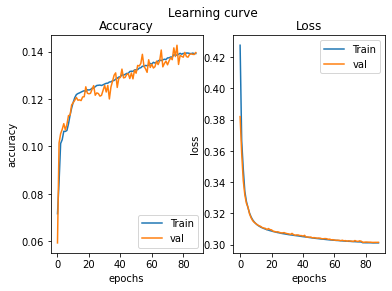

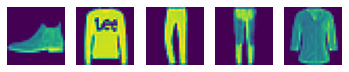

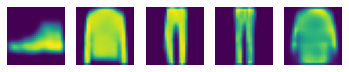

In [2]:
def def_early_stopping():
    return tf.keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience= 10,
            min_delta = 0.0001)

def def_reduce():
    return tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_loss",
            patience = 5,
            verbose= 1)

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Permute((2,1),input_shape=[28, 28]),
    tf.keras.layers.GaussianNoise(0.2),
    tf.keras.layers.GRU(14, return_sequences=True),
    tf.keras.layers.GRU(7)
],name = "encoder")
decoder = tf.keras.models.Sequential([
    tf.keras.layers.RepeatVector(28, input_shape=[7]),
    tf.keras.layers.GRU(14, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(28, activation="sigmoid")),
    tf.keras.layers.Permute((2,1))
],name = "decoder")
rec_ae = tf.keras.models.Sequential([encoder, decoder],name = "autoencoder")
rec_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Nadam(),
                     metrics=["accuracy"])

cb_es = def_early_stopping()
cb_rd = def_reduce()

hist = rec_ae.fit(X_train, X_train, epochs=200, validation_data=(X_valid, X_valid),callbacks=[cb_es,cb_rd],shuffle = True,use_multiprocessing=True)

rec_ae.summary()

plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["Train","val"])
plt.title("Accuracy")

plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train","val"])
plt.title("Loss")

plt.suptitle("Learning curve")
plt.show()

for i in range(5):
    plt.subplot(1,5,i + 1)
    plt.imshow(X_test[i])
    plt.axis("off")
plt.show()

for i in range(5):
    plt.subplot(1,5,i + 1)
    plt.imshow(rec_ae.predict(X_test[i].reshape(1,X_test.shape[1],X_test.shape[2])).reshape(X_test.shape[1],X_test.shape[2]))
    plt.axis("off")
plt.show()

### `Val_acc`の比較
- コピペのまま：0.078前後
- セル数/セルタイプと最適化関数を変更：0.072前後…セル数を減らしているので当然の結果
- 行列を入れ替え：0.099前後…何故か高くなった
- ノイズ除去層を追加：0.079前後 まだ伸びそう
- 学習率減衰と早期打ち切りを導入して100回学習：90回走って0.1291
- 学習毎にデータをシャッフル：89回走って0.1396

---

## わかったこと
- コピペコードならちゃんと動いた
- 入力段の転置は`tf.keras.layers.Permute()`で可能
- `tf.keras.layers.GaussianNoise()`も適用可能 これによってセル数が少なくても強力なモデルを作れる